# Analysis of Ou 5 central star using post-AGB tracks

Originally based on what I did for the Turtle, using Miller Bertolami 2016. But I intent to also use MIST tracks, which have a finer grid of masses


In [146]:
import numpy as np
from astropy.table import Table
from pathlib import Path

In [147]:
datadir = Path("../cspn-tables")

## Miller Bertolami tracks

In [148]:
byte_by_byte_description = """
Byte-by-byte Description of file:
--------------------------------------------------------------------------------
   Bytes Format Units     Label       Explanations
--------------------------------------------------------------------------------
   1-  5  I5    ---       N           Track point number
   7- 15  F9.6  [Lsun]    logL        logarithm of the stellar luminosity
  17- 25  F9.6  [K]       logTeff     logarithm of the effective temperature
  27- 35  F9.6  [cm/s2]   logg        logarithm of the surface gravity
  40- 51  F12.4 yr        t           Age since the point at LogTeff=3.85
  53- 61  F9.6  ---       Menv        Fractional mass of the envelope
  63- 71  F9.6  Msun      Mstar       Total mass of the star
  73- 82  F10.6 [Msun/yr] log(-dM/dt)  Logarithm of the Mass Loss Rate,
                                       log(-dMstar/dt)
--------------------------------------------------------------------------------
"""

In [149]:
def read_tracks(datafile):
    """Read each Miller–Bertolami track into a separate astropy.table
    
    Input argument `datafile` is a CDS file containing all tracks 
    for a given metallicity, e.g., "0100_t03.dat"
    
    Returns list of tables. Each table has a metadata "comments" field 
    that contains additional info (mass and surface composition). 
    """
    with open(datafile) as f:
        # Each track is separated by two blank lines
        tracks = f.read().split("\n\n\n")[:-1]
        tables = []
        for track in tracks:
            lines = track.split("\n")
            metadata = lines[:6]
            data = lines[7:]
            datastring = "\n".join(
                [byte_by_byte_description] + data
            )
            table = Table.read(datastring, format="ascii.cds")
            table.meta["comments"] = metadata
            tables.append(table)
    return tables

In [150]:
tabs = read_tracks(datadir / "miller-bertolami-2006" / "0100_t03.dat")
[_.meta for _ in tabs]

[{'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.000000     0.531867      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .701     .289     .133E-02 .105E-02 .474E-02']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.250000     0.565954      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .586     .310     .733E-01 .990E-03 .248E-01']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   1.500000     0.583201      301',
   '# Surface composition:',
   '#     H      He        C        N        O',
   '#  .700     .285     .503E-02 .117E-02 .592E-02']},
 {'comments': ['# Post-AGB, H-burner',
   '# Initial Mass, Final Mass, Number Track Points',
   '#   2.000000     0.582574      301',
   '# Surface composition:',
   '#     H      He        C     

In [151]:
10**3.589592

3886.79826324366

In [152]:
tabs[2].show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [153]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("talk")
sns.set_color_codes()

Plot of effective temperature versus gravity, which we compare with the Ou 5 observed values.

In [154]:
def extract_masses(data):
    _, Mi, Mf, _ = data.meta["comments"][2].split()
    return round(float(Mi), 2), round(float(Mf), 3)

### Kiel diagram

Make it into a Kiel diagram like in Jones+2022

In [155]:
log_g, dlog_g = 6.659, 0.068
# say 10% uncertainty in T
T, dT = 115, 10

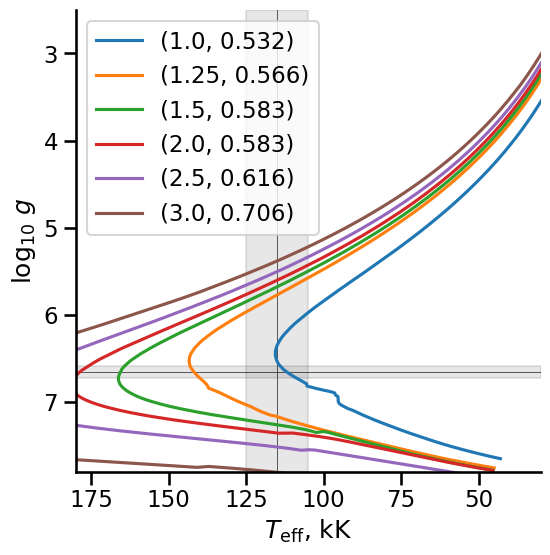

In [156]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvspan(T - dT, T + dT, color="k", alpha=0.1)
ax.axvline(T, color="k", lw=0.5)
ax.axhspan(log_g - dlog_g, log_g + dlog_g, color="k", alpha=0.1)
ax.axhline(log_g, color="k", lw=0.5)
for data in tabs:
    try:
        Mi, Mf = extract_masses(data)
        label = f"({Mi}, {Mf})"
    except:
        continue
    ax.plot(
        0.001 * 10**data["logTeff"], data["logg"],
        label=label,
    )
ax.legend()
ax.set(
    ylabel=r"$\log_{10}\, g$",
    xlabel=r"$T_{\mathrm{eff}}$, kK",
    ylim=[7.8, 2.5],
    xlim=[180, 30],
)
sns.despine()
None

From this we would conclude that the $1\,M_\odot$ model is the best fit, and it is also consistent with the gravity from the final mass of 0.5 or so

### Time evolution

Next, look at the timescales.

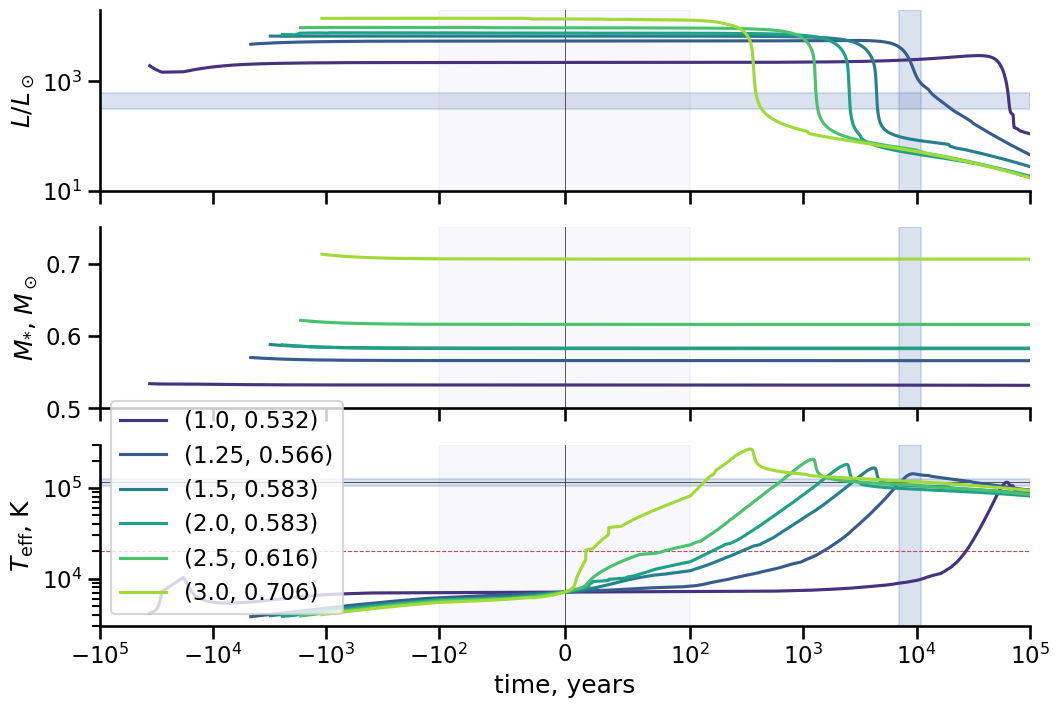

In [157]:
with sns.color_palette("viridis", n_colors=len(tabs)):
    fig, [axL, axM, ax] = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
    ax.axhspan(1000 * (T - dT), 1000 * (T + dT), color="b", alpha=0.2)
    ax.axhline(1000 * T, color="k", lw=0.5)
    ax.axhline(20000, color="r", ls="--", lw=0.8)
    
    axL.axhspan(310, 600, color="b", alpha=0.2)
    for axx in axL, axM, ax:
        axx.axvline(0.0, color="k", lw=0.5)
        axx.axvspan(-100, 100, color="m", alpha=0.05)
        axx.axvspan(7e3, 11e3, color="b", alpha=0.2)
    for data in tabs:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        data["Teff"] = 10**data["logTeff"]
        data["L"] = 10**data["logL"]
        data["Mdot"] = 10**data["log(-dM/dt)"]
        ax.plot(
            "t", "Teff",
            data=data, label=label,
        )
        axM.plot(
            "t", "Mstar",
            data=data, label=label,
        )
        axL.plot(
            "t", "L",
            data=data,
        )
    ax.legend()
    ax.set(
        xlabel="time, years",
        ylabel=r"$T_{\mathrm{eff}}$, K",
        xlim=[-100000, 100000],
        ylim=[3000, 3e5],
    )
    ax.set_xscale("symlog", linthresh=100)
    ax.set_yscale("log")
    axL.set(
        ylim=[None, None],
        ylabel=r"$L / L_\odot$",
    )
    axL.set_yscale("log")
    axL.set_ylim(10, 2e4)
    axM.set(
        ylim=[0.5, 0.75],
        ylabel=r"$M_{*}$, $M_\odot$",
        yscale="linear",
    )
    sns.despine()

So, this shows the problem with the (1.0, 0.532) model. It takes far too long to heat up to < 1e5 K.

On the other hand, the (1.25, 0.566) model is more or less the right T at 8000 years, but is several times too luminous (2000 Lsun)

In [158]:
def make_table_of_times(tabs, Teff):
    logTeff = np.log10(Teff)
    tTkey = f"t({Teff})"
    rslts = {
        "Mi": [],
        "Mf": [],
        tTkey: [],
        "t_cross": [],
        "t_tr": [],
    }
    for data in tabs:
        Mi, Mf = extract_masses(data)
        rslts["Mi"].append(Mi)
        rslts["Mf"].append(Mf)
        # First time to reach given Teff
        mask = data["logTeff"] >= logTeff
        tT = data[mask]["t"].min()
        rslts[tTkey].append(tT)
        # Time to cross to maximum Teff
        icross = data["logTeff"].argmax()
        rslts["t_cross"].append(data[icross]["t"])
        # Transition time before t = 0
        rslts["t_tr"].append(-data["t"].min())
    return Table(rslts)

In [159]:
times = make_table_of_times(tabs, 75000)

In [160]:
times

Mi,Mf,t(75000),t_cross,t_tr
float64,float64,float64,float64,float64
1.0,0.532,49707.8002,62954.7293,36100.5608
1.25,0.566,5246.1258,9299.4885,4611.4263
1.5,0.583,1788.4258,4215.0691,3099.6772
2.0,0.583,889.0794,2404.3056,2427.0822
2.5,0.616,396.8848,1215.2703,1670.3951
3.0,0.706,94.5854,339.101,1083.7751


### HR diagram with kinematic ages

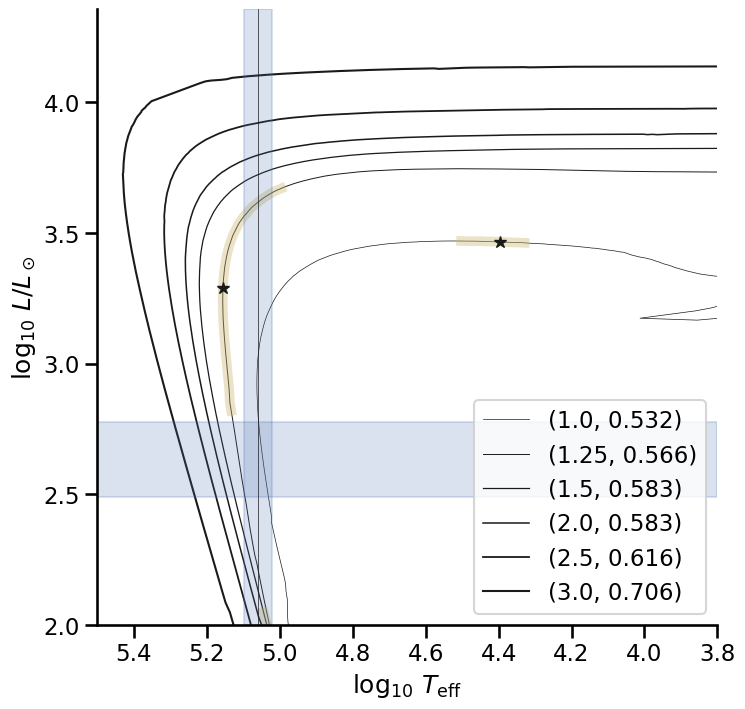

In [161]:
fig, ax = plt.subplots(figsize=(8, 8))
#ax.axvspan(4.7, 5.0, 0.6, 0.9, color="k", alpha=0.1)

ax.axvspan(np.log10(1000 * (T - dT)), np.log10(1000 * (T + dT)), color="b", alpha=0.2)
ax.axvline(np.log10(1000 * T), color="k", lw=0.5)
ax.axhspan(np.log10(310), np.log10(600), color="b", alpha=0.2)

lw = 0.5
tkin = 8200.0
# logTion = 4.3
logTion = np.log10(15_000)
for data in tabs:
    try:
        Mi, Mf = extract_masses(data)
        label = f"({Mi}, {Mf})"
    except:
        continue
    ax.plot(
        "logTeff", "logL",
        data=data, label=label,
        zorder=-100, c="k", lw=lw,
    )
    t0 = np.interp(logTion, data["logTeff"], data["t"])
    logT = np.interp(tkin + t0, data["t"], data["logTeff"])
    logL = np.interp(tkin + t0, data["t"], data["logL"])
    ax.plot(logT, logL, "*", c="k")
    m = (data["t"] > t0 + tkin/1.5) & (data["t"] < t0 + tkin*1.5)
    ax.plot(
        "logTeff", "logL",
        data=data[m], label="_nolabel_",
        zorder=-100, c="y", lw=7, alpha=0.4,
    )
    lw += 0.2
    
ax.legend()
ax.set(
    ylabel="$\log_{10}\, L/L_\odot$",
    xlabel="$\log_{10}\, T_{\mathrm{eff}}$",
    xlim=[5.5, 3.8],
    ylim=[2.0, None],
)
sns.despine()
fig.savefig("hr-planetaries.pdf")
None

So, when we look at it like this, then none of the models seem to work

## Now try the MIST tracks

In [298]:
mist_variant = ""
# mist_variant = "-norot"

In [299]:
mist_files = sorted((datadir / f"MIST{mist_variant}").glob("*.track.eep"))
mist_files

[PosixPath('../cspn-tables/MIST/0010000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0010500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0011000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0011500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0012000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0012500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0013000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0013500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0014000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0014500M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015200M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015400M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015600M.track.eep'),
 PosixPath('../cspn-tables/MIST/0015800M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016000M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016100M.track.eep'),
 PosixPath('../cspn-tables/MIST/0016200M.track.eep'),
 PosixPath('../cspn-tables/M

In [300]:
mist_tables = [
    Table.read(p, format="ascii.commented_header", 
               guess=False, fast_reader=False, header_start=-1)
    for p in mist_files
]

Significant rows correspond to `EEP_number - 1` (Equivalent evolutionary points)

In [301]:
iAGB = 808 - 1
iPost = 1409 - 1
iWD = 1710 - 1

### Masses of the models

Initial masses

In [302]:
m_init = [np.round(tab["star_mass"][0], 4) for tab in mist_tables]

Final masses

In [303]:
m_agb = [np.round(tab["star_mass"][iAGB], 4) for tab in mist_tables]
m_post = [np.round(tab["star_mass"][iPost], 4) for tab in mist_tables]
m_wd = [np.round(tab["star_mass"][iWD], 4) for tab in mist_tables]

In [304]:
mass_tab = Table({
    "Initial": m_init,
    "AGB": m_agb,
    "Post-AGB": m_post,
    "Final": m_wd,
})

In [305]:
mass_tab["Label"] = [f"{_mi:.2f}, {_mf:.4f}" for _mi, _, _, _mf in mass_tab]

In [306]:
mass_tab

Initial,AGB,Post-AGB,Final,Label
float64,float64,float64,float64,str12
1.0,0.9456,0.5989,0.5398,"1.00, 0.5398"
1.05,0.9992,0.6085,0.5423,"1.05, 0.5423"
1.1,1.0525,0.6126,0.5459,"1.10, 0.5459"
1.15,1.1051,0.6124,0.5478,"1.15, 0.5478"
1.2,1.1574,0.6261,0.5505,"1.20, 0.5505"
1.25,1.2096,0.6128,0.5528,"1.25, 0.5528"
1.3,1.2616,0.6319,0.5558,"1.30, 0.5558"
1.35,1.3134,0.6319,0.5581,"1.35, 0.5581"
1.4,1.365,0.63,0.5616,"1.40, 0.5616"


In [307]:
mist_tab = mist_tables[-1]

In [308]:
mist_tab.meta

{'comments': ['MIST version number  = 1.2',
  'MESA revision number =     7503',
  '--------------------------------------------------------------------------------------',
  'Yinit        Zinit   [Fe/H]   [a/Fe]  v/vcrit',
  '0.2703  1.42857E-02     0.00     0.00     0.40',
  '--------------------------------------------------------------------------------------',
  'initial_mass   N_pts   N_EEP   N_col   phase        type',
  '2.5000000000E+00    1710      10      77     YES    low-mass',
  'EEPs:        1     202     353     454     605     631     707     808    1409    1710',
  '--------------------------------------------------------------------------------------',
  '1                               2                               3                               4                               5                               6                               7                               8                               9                              10                            

In [309]:
mist_tab.colnames

['star_age',
 'star_mass',
 'star_mdot',
 'he_core_mass',
 'c_core_mass',
 'o_core_mass',
 'log_L',
 'log_L_div_Ledd',
 'log_LH',
 'log_LHe',
 'log_LZ',
 'log_Teff',
 'log_abs_Lgrav',
 'log_R',
 'log_g',
 'log_surf_z',
 'surf_avg_omega',
 'surf_avg_v_rot',
 'surf_num_c12_div_num_o16',
 'v_wind_Km_per_s',
 'surf_avg_omega_crit',
 'surf_avg_omega_div_omega_crit',
 'surf_avg_v_crit',
 'surf_avg_v_div_v_crit',
 'surf_avg_Lrad_div_Ledd',
 'v_div_csound_surf',
 'surface_h1',
 'surface_he3',
 'surface_he4',
 'surface_li7',
 'surface_be9',
 'surface_b11',
 'surface_c12',
 'surface_c13',
 'surface_n14',
 'surface_o16',
 'surface_f19',
 'surface_ne20',
 'surface_na23',
 'surface_mg24',
 'surface_si28',
 'surface_s32',
 'surface_ca40',
 'surface_ti48',
 'surface_fe56',
 'log_center_T',
 'log_center_Rho',
 'center_degeneracy',
 'center_omega',
 'center_gamma',
 'mass_conv_core',
 'center_h1',
 'center_he4',
 'center_c12',
 'center_n14',
 'center_o16',
 'center_ne20',
 'center_mg24',
 'center_si28'

In [310]:
mist_tab.show_in_notebook()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

### Plot the MIST time evolution, compared with MB

In [311]:
from astropy.constants import R_sun
import astropy.units as u

In [312]:
R_sun.cgs.value

69570000000.0

In [313]:
(1 * u.km).cgs.value

100000.0

Range of allowed kinematic timescales

In [314]:
tkin_min, tkin, tkin_max = 7.5e3, 9e3, 10.5e3

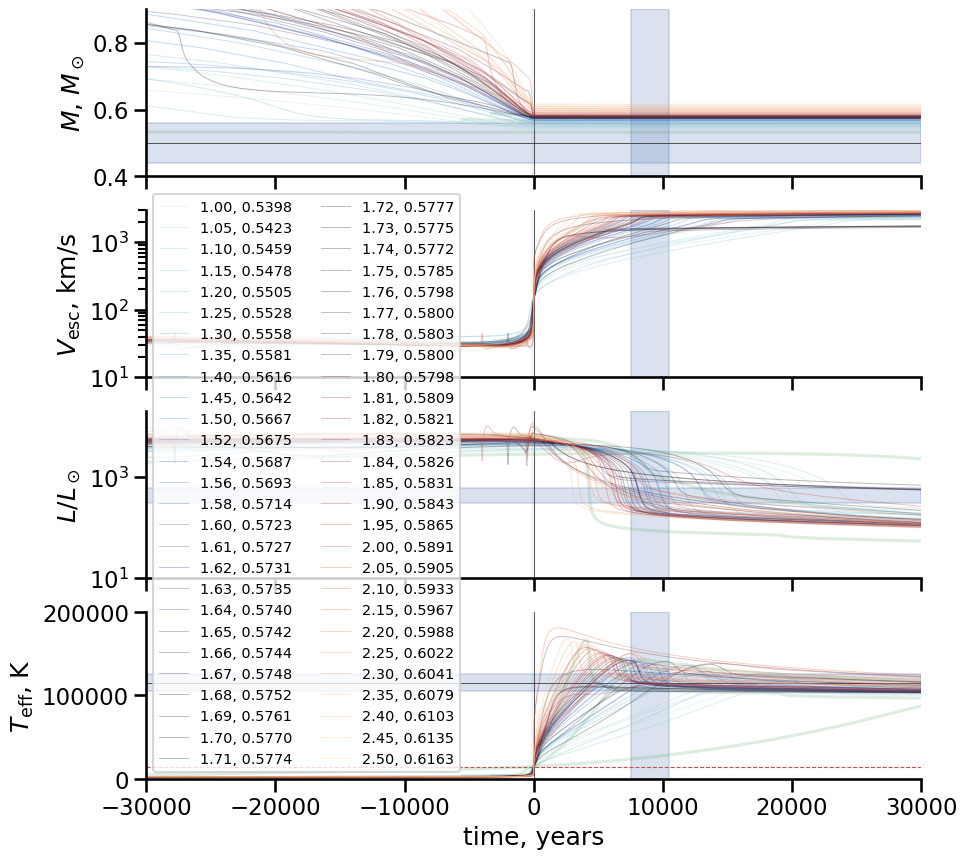

In [315]:
with sns.color_palette("icefire", n_colors=len(mist_tables)):

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
    axM, axV, axL, ax = axes
    ax.axhspan(1000 * (T - dT), 1000 * (T + dT), color="b", alpha=0.2)
    ax.axhline(1000 * T, color="k", lw=0.5)
    ax.axhline(15_000, color="r", ls="--", lw=0.8)
    
    axL.axhspan(310, 600, color="b", alpha=0.2)

    axM.axhline(0.5, color="k", lw=0.5)
    axM.axhspan(0.5 - 0.06, 0.5 + 0.06, color="b", alpha=0.2)
    
    for axx in axes:
        axx.axvline(0.0, color="k", lw=0.5)
        axx.axvspan(-100, 100, color="m", alpha=0.05)
        axx.axvspan(tkin_min, tkin_max, color="b", alpha=0.2)
    
    # Miller Bertolami as pale lines
    alphaMB = 0.2
    for data in tabs[:3]:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        data["Teff"] = 10**data["logTeff"]
        data["L"] = 10**data["logL"]
        data["Mdot"] = 10**data["log(-dM/dt)"]
        # Time zerop point is where T_eff = 20,000 K
        t00 = np.interp(logTion, data["logTeff"], data["t"])
        age = data["t"] - t00
        ax.plot(
            age, data["Teff"],
            # label=label,
            label=None,
            alpha=alphaMB,
            color="g",
        )
        axM.plot(
            age, data["Mstar"],
            # label=label,
            label=None,
            alpha=alphaMB,
            color="g",
         )
        axL.plot(
            age, data["L"],
            label=None,
            alpha=alphaMB,
            color="g",
         )
    
    # MIST tracks
    mist_plot_kws = dict(lw=0.7, alpha=0.3)
    for label, data in zip(mass_tab["Label"], mist_tables):
        # Where MIST says that post-AGB starts
        t0 = data["star_age"][iPost]
        # But for MB comparison we want consistent time zero point 
        # Choose where T_eff = 20,000 K
        t00 = np.interp(logTion, data["log_Teff"], data["star_age"])
        age = data["star_age"] - t00
        ax.plot(
            age,
            10**data["log_Teff"],
            label=label,
            **mist_plot_kws,
        )
        # axMd.plot(
        #     age,
        #     -data["star_mdot"],
        #     **mist_plot_kws,
        # )
        axM.plot(
            age,
            data["star_mass"],
            **mist_plot_kws,
        )
        axL.plot(
            age,
            10**data["log_L"],
            **mist_plot_kws,
        )
        g = 10**data["log_g"] * u.cm / u.s **2
        R = 10**data["log_R"] * R_sun
        v_esc = np.sqrt(2 * g * R).to_value(u.km / u.s)
        axV.plot(
            age,
            # data["v_wind_Km_per_s"],
            v_esc,
            **mist_plot_kws,
        )
            
    ax.legend(ncol=2, fontsize="xx-small")
    ax.set(
        xlabel="time, years",
        ylabel=r"$T_{\mathrm{eff}}$, K",
        xlim=[-30_000, 30_000],
        ylim=[0, 2e5],
    )
    # ax.set_xscale("symlog", linthresh=3000)
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    axL.set_ylabel(r"$L / L_\odot$")
    axL.set_yscale("log")
    axL.set_ylim(10, 2e4)
    axM.set(
        ylim=[0.4, 0.9],
        ylabel=r"$M$, $M_\odot$",
        yscale="linear",
    )
    axV.set(
        ylim=[10, 3000],
        ylabel=r"$V_\mathrm{esc}$, km/s",
        yscale="log",
    )
    sns.despine()

### MIST Kiel diagram

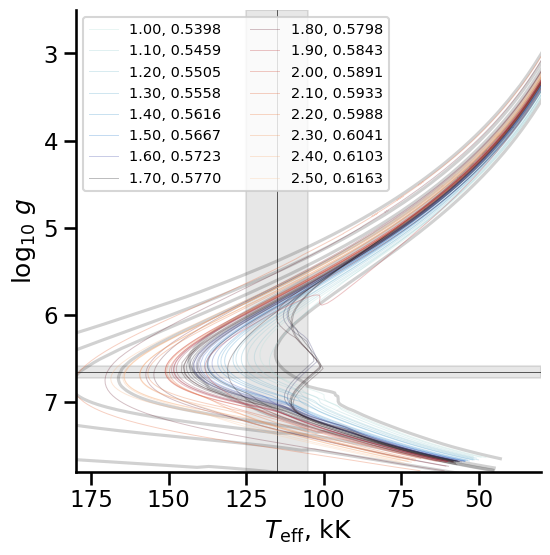

In [316]:
with sns.color_palette("icefire", n_colors=len(mist_tables)):

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axvspan(T - dT, T + dT, color="k", alpha=0.1)
    ax.axvline(T, color="k", lw=0.5)
    ax.axhspan(log_g - dlog_g, log_g + dlog_g, color="k", alpha=0.1)
    ax.axhline(log_g, color="k", lw=0.5)
    for data in tabs:
        try:
            Mi, Mf = extract_masses(data)
            label = f"({Mi}, {Mf})"
        except:
            continue
        ax.plot(
            0.001 * 10**data["logTeff"], data["logg"],
            label=None, alpha=alphaMB, color="k",
        )
    for data, label in zip(mist_tables, mass_tab["Label"]):
        if label[3] == "0":
            _label = label
        else:
            _label = "_"
        ax.plot(
            0.001 * 10**data["log_Teff"],
            data["log_g"],
            label=_label,
            **mist_plot_kws,
        )
    
    ax.legend(ncol=2, fontsize="xx-small")
    ax.set(
        ylabel=r"$\log_{10}\, g$",
        xlabel=r"$T_{\mathrm{eff}}$, kK",
        ylim=[7.8, 2.5],
        xlim=[180, 30],
    )
    sns.despine()
...;

In [317]:
label[3] == "0"

True

I do not understand why the M_f ~ 0.574 tracks have such high log g ~ 7 at the point where T = 120 kK

### MIST table of results

I want to separate the table from the plotting

In [318]:
def stats_from_track(data, columns, tzero, t, dt, return_mask=False):
    """
    Calculate mean and limits of selected `columns` from MIST model `data` for time `tzero` + `t` +/- `dt`
    """
    mask = (data["star_age"] > tzero + t - dt) & (data["star_age"] < tzero + t + dt)
    rslt = {}
    rslt["t"] = t
    rslt["dt"] = dt
    rslt["tzero"] = tzero
    for column in columns:
        rslt[column] = np.interp(tzero + t, data["star_age"], data[column])
        if mask.any():
            rslt[column + "_MIN"] = np.min(data[column][mask])
            rslt[column + "_MAX"] = np.max(data[column][mask])
        else:
            rslt[column + "_MIN"] = np.nan
            rslt[column + "_MAX"] = np.nan
    if return_mask:
        return rslt, mask
    else:
        return rslt

In [319]:
def get_all_stats_at_time(
    time: float,
    dtime: float,
    mist_tables: list[Table],
    columns: list[str] = ["log_Teff", "log_L", "star_mass", "log_R", "log_g"],
    Teff_zero: float = 1.0e4,
    return_masks: bool = False,
) -> Table:
    """
    Return a Table of selected `columns` from the MIST model tracks in `mist_tables`. 
    
    Each is evaluated at fuzzy `time` +/- `dtime`.
    The zero-point of the post-AGB track is when effective temperature first passes `Teff_zero` (default: 1e4 K)
    If `return_masks` is True, also return a list of masks into each track that selects `time` +/- `dtime`
    """
    savedata, masks = [], []
    for data in mist_tables:
        # Calculate zero point for ages: T_eff > 10_000 K
        t00 = np.interp(logTion, data["log_Teff"], data["star_age"])
        stats, m = stats_from_track(
            data, 
            columns, 
            tzero=t00, 
            t=time, 
            dt=dtime,
            return_mask=True,
        )
        savedata.append(stats)
        masks.append(m)
    if return_masks:
        return Table(savedata), masks
    else:
        return Table(savedata)

#### Define the distance

In [396]:
D_kpc = 4
# D_kpc = 3
# D_kpc = 7

Use looser bounds on the kinematic age: $8.2 \pm 1$ (if we go with this, I need to update what the table in the paper says).

We also want to investigate what happens if we change the distance, so we introduce `D_scale` = $D / \mathrm{4\,kpc}$

In [397]:
# tkin, dtkin = 8.2e3, 0.4e3
D_scale = D_kpc / 4
tkin, dtkin = D_scale * 8.2e3, D_scale * 1e3
L_obs_min, L_obs_max = 310 * D_scale ** 2, 600 * D_scale ** 2 

In [398]:
tkin_tab, tkin_masks = get_all_stats_at_time(tkin, dtkin, mist_tables, Teff_zero=1e4, return_masks=True)

In [399]:
len(tkin_tab), len(mass_tab)

(54, 54)

Combine the tables and add in a column with the masks, but we have to make a pandas dataframe first if we want to use one later, since it does not support maak arrays in cells

In [400]:
full_tab = mass_tab | tkin_tab

In [401]:
df = full_tab.to_pandas()

In [402]:
full_tab["mask"] = tkin_masks

In [403]:
full_tab[::2]

Initial,AGB,Post-AGB,Final,Label,t,dt,tzero,log_Teff,log_Teff_MIN,log_Teff_MAX,log_L,log_L_MIN,log_L_MAX,star_mass,star_mass_MIN,star_mass_MAX,log_R,log_R_MIN,log_R_MAX,log_g,log_g_MIN,log_g_MAX,mask
float64,float64,float64,float64,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool[1710]
1.0,0.9456,0.5989,0.5398,"1.00, 0.5398",8200.0,1000.0,11462939138.896433,4.82715809971843,4.799521039948045,4.856876599305421,3.4800186698369777,3.469796080074069,3.487785538940399,0.5398582834828398,0.5398517116035125,0.539865474841257,-0.3916297123362568,-0.4561780063916933,-0.3324721582437778,4.9536854117227485,4.835376088661114,5.0827767129868935,False .. False
1.1,1.0525,0.6126,0.5459,"1.10, 0.5459",8200.0,1000.0,8185145256.7110195,4.898218927105285,4.863983444327154,4.928904698947246,3.4886610356534917,3.4725809004586035,3.502753440796619,0.5459096664981363,0.5459049518050421,0.5459163959007441,-0.5294301842017125,-0.5988417954830773,-0.45391301607388584,5.234127370449359,5.0830983876882865,5.372946842256007,False .. False
1.2,1.1574,0.6261,0.5505,"1.20, 0.5505",8200.0,1000.0,6077864488.82644,5.003158782266317,4.967562940039689,5.031395051396483,3.4558627285721917,3.4202485004586984,3.4883001275934644,0.5505323278746168,0.5505303941050742,0.5505357714396872,-0.7557090480644237,-0.8299887003815045,-0.6682986641005321,5.690347140002839,5.515529088567087,5.838904919155512,False .. False
1.3,1.2616,0.6319,0.5558,"1.30, 0.5558",8200.0,1000.0,4642093688.965176,4.985816022826715,4.9526178273507435,5.017497520330911,3.48350575723046,3.451294421735178,3.5085761291641564,0.5557811907657109,0.5557783860167358,0.5557851990160857,-0.7072020148560887,-0.7866706776121206,-0.6282704379372942,5.59745409218694,5.439594070435866,5.756389226027059,False .. False
1.4,1.365,0.63,0.5616,"1.40, 0.5616",8200.0,1000.0,3639464338.663406,5.023519788459208,4.987924119902799,5.051718034579743,3.475868611790088,3.437562710206769,3.51014039100978,0.5616525079919523,0.5616506028408267,0.561655939313858,-0.7864281188412597,-0.8619775618739864,-0.6981008921185955,5.760470157755953,5.583818357551925,5.911567570672137,False .. False
1.5,1.468,0.6541,0.5667,"1.50, 0.5667",8200.0,1000.0,2914515435.429324,5.132074361375288,5.113461890765927,5.1387233124815275,3.2736422508531997,3.0967109177350367,3.375612958852199,0.5666910848706622,0.5666909611142971,0.566691496954998,-1.1046504451418633,-1.2054066631950948,-1.016440149923641,6.400793488259539,6.224373213631639,6.60230582952295,False .. False
1.54,1.5092,0.6588,0.5687,"1.54, 0.5687",8200.0,1000.0,2683388114.0117435,5.121480732690342,5.0987606757637085,5.136196712308721,3.3328857602120197,3.1976364062499116,3.415545712978166,0.5686551687998712,0.5686549043251563,0.568655823152767,-1.0538414330925592,-1.1508980693103745,-0.9670713428562205,6.30067807477088,6.127138394041637,6.494791145221299,False .. False
1.58,1.5505,0.6648,0.5714,"1.58, 0.5714",8200.0,1000.0,2485856662.59898,5.055918864912474,5.016925913943135,5.0864936057416354,3.4805379064111657,3.42614568069778,3.5250347609745702,0.5714294370000278,0.571427765793006,0.5714327516010473,-0.8488916244372505,-0.9372372189522666,-0.7486572952168723,5.892892075594629,5.692425936290364,6.069581994481769,False .. False
1.61,1.5815,0.6633,0.5727,"1.61, 0.5727",8200.0,1000.0,2343646787.529629,5.144962377765624,5.073412254785213,5.149396286447128,3.035422809644909,2.453451659962572,3.2871431885850018,0.5726918429004252,0.5726918384920747,0.5726919567415244,-1.2495361985266813,-1.3974215274070243,-1.1220497629814918,6.695139523120892,6.440166738364102,6.990910177538604,False .. False


### MIST HR diagram

In [404]:
def limits(a, b, ax):
    """Helper function for converting from data to fractional axis coordinates"""
    if a > b:
        a, b = b, a
    ymin, ymax = ax.get_ylim()
    return ((y - ymin) / (ymax - ymin) for y in (a, b))

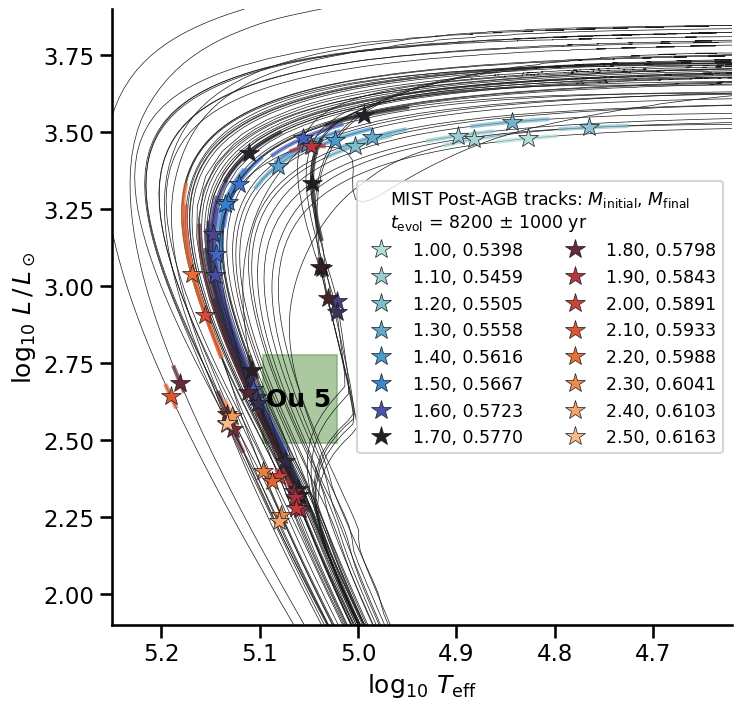

In [405]:
istart, istep = 0, 1
# istart, istep = 0, 1
with sns.color_palette("icefire", n_colors=1 + len(full_tab[istart::istep])):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    lw = 0.5
    for tdata, mist_data in zip(full_tab[istart::istep], mist_tables[istart::istep]):
        # Plot the evolutionary track
        ax.plot(
            "log_Teff", "log_L",
            data=mist_data, label="_nolabel_",
            zorder=-100, c="k", lw=lw,
        )
        logT = tdata["log_Teff"]
        logL = tdata["log_L"]
        # Put symbol at kinematic age
        if tdata["Label"][3] == "0":
            _label = tdata["Label"]
        else:
            _label = "_"
        line, = ax.plot(logT, logL, "*", markersize=15, mew=0.5, mec="k", label=_label)
        # Indicate uncertainty range in kinematic age
        m = tdata["mask"]
        ax.plot(
            "log_Teff", "log_L",
            data=mist_data[m], label="_nolabel_",
            zorder=-100, c=line.get_color(), lw=3, alpha=0.7,
        )

    ou5_text = "Ou 5"
    ax.text(3 + np.log10(T), np.log10(430), ou5_text, fontweight="black", ha="center", va="center")
    title = (
        r"MIST Post-AGB tracks: $M_\mathrm{initial}$, $M_\mathrm{final}$"
        "\n"
        rf"$t_\mathrm{{evol}}$ = {tkin:.0f} $\pm$ {dtkin:.0f} yr"
    )
    ax.legend(
        ncol=2, 
        loc="right",
        fontsize="x-small",
        title=title, 
        title_fontsize="x-small",
    )
    ax.set(
        ylabel=r"$\log_{10}\, L\,/\,L_\odot$",
        xlabel=r"$\log_{10}\, T_{\mathrm{eff}}$",
        xlim=[5.25, 4.62],
        ylim=[1.9, 3.9],
    )
    ax.axvspan(
        np.log10(1000 * (T - dT)), np.log10(1000 * (T + dT)),
        *limits(np.log10(L_obs_min), np.log10(L_obs_max), ax),
        color="xkcd:dull green", alpha=0.6, zorder=-1000,
    )

    sns.despine()
    fig.savefig(f"hr-mist{mist_variant}-ou5-D{D_kpc:.0f}.pdf", bbox_inches="tight")
...;

In [406]:
tdata["Label"][3]

'0'

### Initial versus final mass

<Axes: xlabel='Initial', ylabel='Final'>

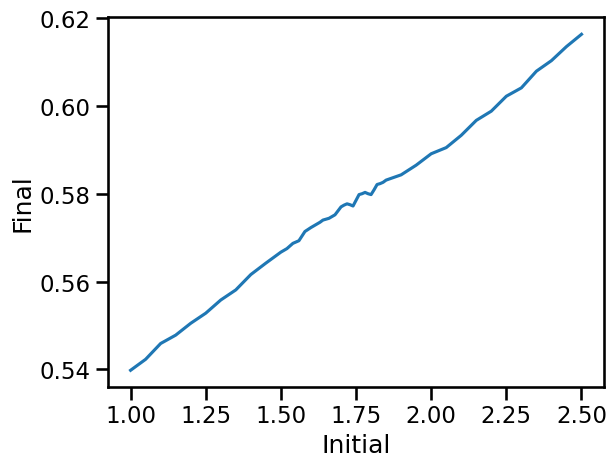

In [407]:
sns.lineplot(mass_tab.to_pandas(), x="Initial", y="Final")

### L, Teff, and R versus M_final

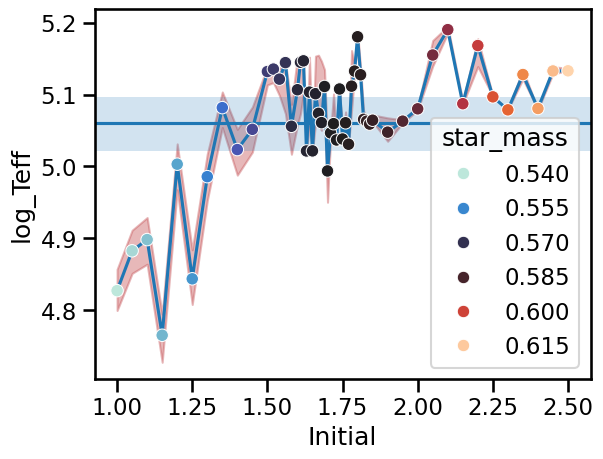

In [408]:
mvar = "Initial"
# mvar = "star_mass"
g = sns.lineplot(df, x=mvar, y="log_Teff")
g.fill_between(x=mvar, y1="log_Teff_MIN", y2="log_Teff_MAX", data=df, color="r", alpha=0.4, zorder=-1000)
sns.scatterplot(df, x=mvar, y="log_Teff", hue="star_mass", palette="icefire", zorder=100)
g.axhline(3 + np.log10(T))
g.axhspan(3 + np.log10(T - dT), 3 + np.log10(T + dT), alpha=0.2)

This shows that many models with M > 0.57 are consistent with T_eff

In [409]:
from matplotlib.colors import Normalize

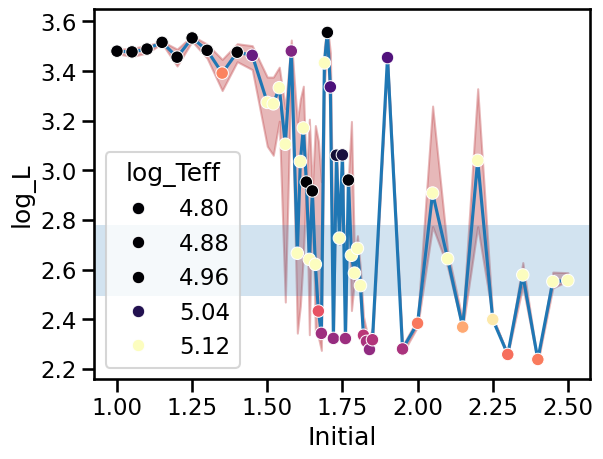

In [410]:
g = sns.lineplot(df, x=mvar, y="log_L")
g.fill_between(x=mvar, y1="log_L_MIN", y2="log_L_MAX", data=df, color="r", alpha=0.4, zorder=-1000)
sns.scatterplot(df, x=mvar, y="log_L", hue="log_Teff", hue_norm=Normalize(vmin=5.03, vmax=5.1), palette="magma", zorder=100)
g.axhspan(np.log10(L_obs_min), np.log10(L_obs_max), alpha=0.2)

This shows that the only ones consistent with log_L are between 0.572 and 0.576

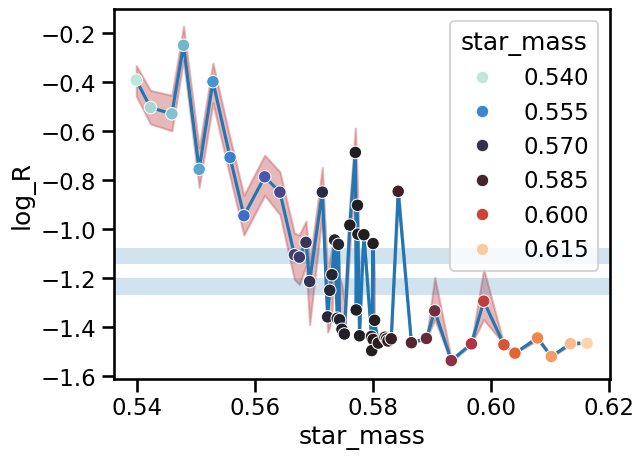

In [411]:
g = sns.lineplot(df, x="star_mass", y="log_R")
g.fill_between(x="star_mass", y1="log_R_MIN", y2="log_R_MAX", data=df, color="r", alpha=0.4, zorder=-1000)
sns.scatterplot(df, x="star_mass", y="log_R", hue="star_mass", palette="icefire", zorder=100,)
R, dR = 0.078, 0.006
g.axhspan(np.log10(R - dR), np.log10(R + dR), alpha=0.2)
R, dR = 0.0587, 0.0046
g.axhspan(np.log10(R - dR), np.log10(R + dR), alpha=0.2)

Make a list of masses to use as input to MIST for different parameter sets

In [412]:
print(" ".join(str(_) for _ in mass_tab["Initial"]))

1.0 1.05 1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.52 1.54 1.56 1.58 1.6 1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68 1.69 1.7 1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8 1.81 1.82 1.83 1.84 1.85 1.9 1.95 2.0 2.05 2.1 2.15 2.2 2.25 2.3 2.35 2.4 2.45 2.5


In [413]:
Table.read.help("ascii.commented_header")

Table.read(format='ascii.commented_header') documentation

Read the input ``table`` and return the table.  Most of the default behavior for
various parameters is determined by the ``format`` argument.

Help on the ``read()`` function arguments is available as shown in this example::

  from astropy.io import ascii
  ascii.read.help()  # Common help for all formats
  ascii.read.help("html")  # Common help plus "html" format-specific args

See also:

- https://docs.astropy.org/en/stable/io/ascii/
- https://docs.astropy.org/en/stable/io/ascii/read.html

Parameters
----------
table : str, file-like, list, `pathlib.Path` object
    Input table as a file name, file-like object, list of string[s],
    single newline-separated string or `pathlib.Path` object.
guess : bool
    Try to guess the table format. Defaults to None.
format : str, `~astropy.io.ascii.BaseReader`
    Input table format
delimiter : str
    Column delimiter string
comment : str
    Regular expression defining a comment line

In [414]:
sns.scatterplot??

Signature:
sns.scatterplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    size=None,
    style=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    legend='auto',
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatter plot with possibility of several semantic groupings.

The relationship between `x` and `y` can be shown for different subsets
of the data using the `hue`, `size`, and `style` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
`hue` and `style` for the same variable) can be helpful for making
graphics more accessible.

See the :ref:`tutorial <relational_tutorial>` for more information.

The de